# Objective
Create a simple process for making a list of Coronavirus-related papers using the Microsoft Academic Graph.

If possible, also find papers on health-policy and health-education. 

## Process
1. Start with a list of  relevant papers after searching Microsoft Academic. Retrieve the PaperIds
2. Pull the details of the papers from the MAG
3. Find related FieldsOfStudy
4. Optionally, also find the _children_ of those FieldsOfStudy
5. Use those FieldsOfStudy to find more related papers
6. Filter those papers for SAGE papers.

In [74]:
%matplotlib inline
import pandas as pd
import numpy as np
import json

In [75]:
import os

# Retrieve the data
1. Peform a basic search 
> https://academic.microsoft.com/search?q=coronavirus%20covid-19%20pandemic&f=&orderBy=0&skip=0&take=10
2. Click the quote marks to build a reference list
<br>
<img src="untitled.png">
3. Download in MS Word format as an xml file
<br>
<img src = "untitled2.png">

Read in the XML data and parse out the MAG PaperIds 

In [76]:
from bs4 import BeautifulSoup as bs
with open('MSA_CV_refs.xml', 'r', encoding = 'utf-8') as f:
    soup = bs(f.read(),'lxml')
pids= [x.text[x.text.rfind('/')+1:] for x in soup.find_all('url')]
len(pids)

40

# now connect to sql

In [78]:
from sqlalchemy import create_engine
def retrieve_sql_data(sql):
    dialect = 'mssql'
    driver = 'pyodbc'
    driver_string = "ODBC+Driver+17+for+SQL+Server"
    username = os.environ['SQL_USER']
    password = os.environ['SQL_PASS']
    host = os.environ['SQL_DATALAKE_SVR']
    port = '1433'
    database = os.environ['SQL_DATALAKE_DB']

    con_s = f"{dialect}+{driver}://{username}:{password}@{host}:{port}/{database}?driver={driver_string}&trusted_connection=yes"
    engine = create_engine(con_s)
    connection = engine.connect()
    df = pd.read_sql(sql,connection)
    connection.close()
    return df

## Find related fieldsofstudy

Get all of the FieldsOfStudy associated with the papers (note that this just gets the Ids of the fieldsofstudy and their scores, but not their names)

In [82]:
%%time
pids = papers['PaperId'].tolist()
s = "( "+ ", ".join(["'"+str(x)+"'" for x in pids]) + ")"
sql = """
        SELECT * FROM [mag].[PaperFieldsOfStudy] WHERE PaperId IN {}
    """.format(s)
pfos = retrieve_sql_data(sql)

Wall time: 17.2 s


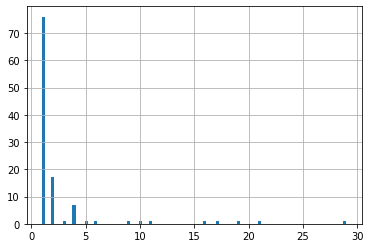

In [83]:
pfos['FieldOfStudyId'].value_counts().hist(bins = 100)

In [84]:
# optionally filter fields of study to only include fields that appear more than n times
# in the input xml
vc = pd.DataFrame(pfos['FieldOfStudyId'].value_counts(ascending = False))
vc.columns = ['count_in_orig_ls']
# greater than n
# n = 1
# gtn = vc[vc['FieldOfStudyId']>n].index.tolist()

Filter for fields with high scores only.

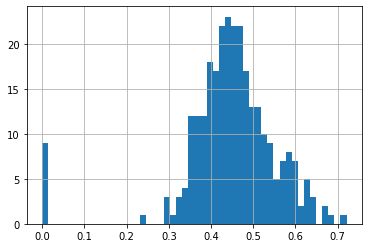

In [85]:
pfos['Score'].hist(bins=50)

In [86]:
# pick a cutoff score
cutoff = 0.4
pfos = pfos[(pfos['Score']>cutoff)] 
pfos = pfos.merge(right = vc, left_on='FieldOfStudyId', right_index=True, how='left')
# pfos = pfos[pfos['count_in_orig_ls']>0]
# pfos = pfos[pfos['FieldOfStudyId'].isin(set(gtn))]
pfos.shape

(216, 4)

In [87]:
best_scores = pfos.groupby('FieldOfStudyId').max()
best_scores = best_scores[['Score']]
best_scores.head()

,Score
FieldOfStudyId,
447327,0.470971
8891405,0.442876
12174686,0.457487
17022365,0.440203
22070199,0.541376


In [88]:
fields = list(set(pfos['FieldOfStudyId'].tolist()))
len(fields)

96

Now retrieve related data on the fields of study. Up until now, we've only had Ids. This will get us the names of the fieldsofstudy so that we can see how relevant they are.

Fields of study have a 'level' associated with them. A level of '0' would be a broad topic, like 'physics' or 'medicine'. A level of '5' might be a very narrow topic like "human mortality from h5n1". So we set our cutoff to avoid taking too broad a swathe of topics. 

In [89]:
%%time
level_cutoff = 1 
s = "( "+ ", ".join(["'"+str(x)+"'" for x in fields]) + ")"
sql = """
        SELECT * FROM [mag].[FieldOfStudy] WHERE FieldOfStudyId IN {} AND Level >{}
    """.format(s,level_cutoff)
fos = retrieve_sql_data(sql)
fos = fos.merge(best_scores, left_on='FieldOfStudyId', right_index=True, how='left')
fos = fos.rename(columns = {'Score':'Best Score'})
fos.shape

Wall time: 2.16 s


(85, 10)

In [90]:
fos = fos.merge(right = vc, left_on='FieldOfStudyId', right_index=True, how='left')

In [124]:
fos = fos.sort_values(['Level','Best Score'], ascending = False)
fos.head(3)

,FieldOfStudyId,Rank,NormalizedName,DisplayName,MainType,Level,PaperCount,CitationCount,CreatedDate,Best Score,count_in_orig_ls
83,2778137277,17006,betacoronavirus,Betacoronavirus,biology.organism_classification,5,180,21345,2018-01-05,0.646165,1
55,2910344980,13069,ebola hemorrhagic fever,Ebola Hemorrhagic Fever,,5,627,23002,2019-01-25,0.595625,1
52,2908625121,14053,coronaviridae infections,Coronaviridae Infections,,5,42,871,2019-01-25,0.589344,1


In [92]:
# optionally write out so that everyone can see what list of topics you're using
# fos.to_excel('fos.xlsx', index=False)

Do some further filtering here.

In [93]:
fieldset = set(pfos[pfos['Score'] > 0.6]['FieldOfStudyId'].tolist())
len(fieldset)

9

In [94]:
fos_subset = fos[(fos['Level']>=3) & (fos['FieldOfStudyId'].isin(fieldset))]

In [95]:
fos_subset.head(3)

,FieldOfStudyId,Rank,NormalizedName,DisplayName,MainType,Level,PaperCount,CitationCount,CreatedDate,Best Score,count_in_orig_ls
83,2778137277,17006,betacoronavirus,Betacoronavirus,biology.organism_classification,5,180,21345,2018-01-05,0.646165,1
25,192805744,25000,human mortality from h5n1,Human mortality from H5N1,,4,4355,86741,2016-06-24,0.721171,1
58,2777691041,13818,middle east respiratory syndrome coronavirus,Middle East respiratory syndrome coronavirus,medicine.disease_cause,4,1408,29372,2018-01-05,0.692007,16
38,2777485425,15423,human coronavirus nl63,Human coronavirus NL63,biology.organism_classification,4,190,22058,2018-01-05,0.626395,1
35,2776525042,14159,middle east respiratory syndrome,Middle East respiratory syndrome,medicine.disease,4,1005,15537,2018-01-05,0.626105,2
48,2780987755,13884,sars coronavirus,SARS coronavirus,biology.organism_classification,4,1747,52299,2018-01-05,0.604757,2
39,2777648638,11040,coronavirus,Coronavirus,medicine.disease_cause,3,8080,215252,2018-01-05,0.675827,17
10,89623803,10852,pandemic,Pandemic,,3,28199,434929,2016-06-24,0.635572,29


MAG's Fieldsofstudy all have 'children'. That is narrower topics which fit within another topic.  So virology might be a child of medicine and coronavirus might be a child of virology.

We probably want all or most of the children of the fieldsofstudy that we have chosen. 

In [96]:
%%time
# add fos children
# now get all SAGE articles with these FOS from the last 3 years
fos_ls = fos_subset['FieldOfStudyId'].tolist()

s = "( "+ ", ".join(["'"+str(x)+"'" for x in fos_ls]) + ")"
sql = """
        SELECT * FROM [mag].[FieldOfStudyChildren] WHERE FieldOfStudyId IN {}
    """.format(s)
children = retrieve_sql_data(sql)
children.shape

Wall time: 1.99 s


(84, 2)

In [97]:
## Add children...
cfields = fields + list(set(children['ChildFieldOfStudyId'].tolist()))
len(cfields)

178

In [98]:
%%time

s = "( "+ ", ".join(["'"+str(x)+"'" for x in cfields]) + ")"
sql = """
        SELECT * FROM [mag].[FieldOfStudy] WHERE FieldOfStudyId IN {}
    """.format(s)
fosc = retrieve_sql_data(sql)
fosc = fosc.merge(best_scores, left_on='FieldOfStudyId', right_index=True, how='left')
fosc = fosc.rename(columns = {'Score':'Best Score'})
fosc.shape

Wall time: 2.92 s


(170, 10)

In [99]:
# fos = fos.merge(right = vc, left_on='FieldOfStudyId', right_index=True, how='left')

Now let's inspect the list.

In [100]:
fosc = fosc.sort_values(['Level'], ascending = False)
fosc.head(10)

,FieldOfStudyId,Rank,NormalizedName,DisplayName,MainType,Level,PaperCount,CitationCount,CreatedDate,Best Score
132,2909397111,25000,monovalent influenza vaccines,Monovalent Influenza Vaccines,,5,11,237,2019-01-25,NaN
155,2910720372,19613,mers virus,MERS virus,,5,17,57,2019-01-25,NaN
130,2909228517,25000,sars coronavirus rna,SARS coronavirus RNA,,5,14,88,2019-01-25,NaN
122,2908854353,16574,mers coronavirus,MERS coronavirus,,5,159,3058,2019-01-25,NaN
117,2908625121,14053,coronaviridae infections,Coronaviridae Infections,,5,42,871,2019-01-25,0.589344
34,142054583,25000,transmission and infection of h5n1,Transmission and infection of H5N1,,5,742,29135,2016-06-24,NaN
115,2781442963,12367,zanamivir,Zanamivir,medicine.drug,5,1762,51749,2018-01-05,0.582309
143,2910344980,13069,ebola hemorrhagic fever,Ebola Hemorrhagic Fever,,5,627,23002,2019-01-25,0.595625
60,2775980723,14699,international health regulations,International Health Regulations,,5,810,6753,2018-01-05,0.541849
147,2911128928,25000,sars coronavirus main protease,SARS coronavirus main protease,,5,21,95,2019-01-25,NaN


In [101]:
fosc.tail(10)

,FieldOfStudyId,Rank,NormalizedName,DisplayName,MainType,Level,PaperCount,CitationCount,CreatedDate,Best Score
37,159047783,8763,virology,Virology,,1,1939379,28941528,2016-06-24,0.457334
36,149923435,8511,demography,Demography,,1,459880,5038224,2016-06-24,0.407006
12,42972112,8162,veterinary medicine,Veterinary medicine,,1,430350,2507330,2016-06-24,0.406581
10,39549134,10124,public relations,Public relations,business.industry,1,1312836,10467633,2016-06-24,0.441667
56,545542383,15067,medical emergency,Medical emergency,medicine.disease,1,443879,3326265,2016-06-24,0.408776
44,187212893,8148,pediatrics,Pediatrics,medicine.medical_specialty,1,1155497,9149968,2016-06-24,0.412734
50,194828623,9395,emergency medicine,Emergency medicine,medicine.medical_specialty,1,576443,2792882,2016-06-24,0.441294
51,203014093,7642,immunology,Immunology,,1,3188282,69151823,2016-06-24,0.423523
53,512399662,10752,family medicine,Family medicine,medicine.medical_specialty,1,1491301,8733015,2016-06-24,0.451957
23,71924100,9382,medicine,Medicine,business.industry,0,27719103,268521371,2016-06-24,0.426224


In [102]:
# write out thelist of fields and children that we are using
# fosc.to_excel('fieldsofstudy_coronavirus.xlsx', index = False)

# Get papers

In [103]:
%%time
# now get all SAGE articles with these FOS from the last X years
fos_ls = fosc[fosc['Level']>2]['FieldOfStudyId'].tolist()

s = "( "+ ", ".join(["'"+str(x)+"'" for x in fos_ls]) + ")"
sql = """
        SELECT * FROM [mag].[PaperFieldsOfStudy] WHERE FieldOfStudyId IN {} AND Score > 0.6
    """.format(s)
rel_pfos = retrieve_sql_data(sql)
rel_pfos.shape



Wall time: 15.6 s


(112186, 3)

In [104]:
# rel_pfos = rel_pfos[rel_pfos['Score']>0.5]
# rel_pfos.shape

In [105]:
years = [x for x in range(2010,2021)]
years

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

In [106]:
%%time
# now get the Papers data for these
rel_pids = rel_pfos['PaperId']
s = "( "+ ", ".join(["'"+str(x)+"'" for x in rel_pids]) + ")"
s2 = "( "+ ", ".join([str(x) for x in years]) + ")"
sql = """
        SELECT PaperId, OriginalTitle, Doi, Year, Date, Publisher, JournalId, CitationCount, EstimatedCitation 
        FROM [mag].[Papers] 
        WHERE PaperId IN {} 
        AND Year IN {} 
        AND DocType = 'Journal'
    """.format(s, s2)
rel_papers = retrieve_sql_data(sql)
rel_papers.shape

Wall time: 7min 11s


(26226, 9)

In [ ]:
rel_papers['Link'] = rel_papers['Doi'].map(lambda x: 'http:/doi/org/'+str(x) if (x!=None) else x)

In [127]:
rel_papers.to_csv('Related_papers.csv', encoding='utf-8-sig', index=False)

There we are! Now we have a big list of Coronavirus-related papers from the Microsoft Academic Graph. We can then filter this list for relevant articles published by SAGE and make them free-to-read.

This was obviously a super-rough process for finding coronavirus-related content. There are certainly a few articles which have nothing to do with coronavirus in the list. One of our goals was to find papers on health-policy and, while we certainly found them, it's clear that a lot of papers we found on health-policy do not have anything to do with the ongoing coronavirus outbreak. There are also surely papers that are relevant to the outbreak that have not been found by this process.

That said, this process provided better overall coverage of SAGE content than a simple keyword search and also saved a huge amount of time compared with manual curation of a list of papers.

### Next steps
If anyone is interested in developing this further, I think that there is an opportunity to create a coronavirus classifier using text data and potentially other MAG data, like reference-data, as well as the fieldsofstudy we used here.

That classifier could be very useful for publishers of subscription content who want to drop the paywall on coronavirus research, but it would also be useful to create a feed of related research for anyone who's interested in keeping up with the latest research on the outbreak. 